# Trabalho Prático II - Aprendizado de Máquina

In [0]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
from keras.utils import np_utils

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

## Resumo dos Dados

O conjunto de dados usado neste notebook é o MNIST, um conjunto de imagens de digitos manuscritos. O dataset contém 60000 imagens de treino e 10000 imagens de teste, cada uma de tamanho 28x28 pixeis. Cada imagem possui um target associado, que é o número do digito na imagem (entre 0 e 9). Este dataset também é disponibilizado no próprio Keras.

Fonte: http://yann.lecun.com/exdb/mnist/

In [0]:
# Carrega as imagens ja separadas entre treino e teste. Na primeira vez eh necessario fazer o download
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
largura = altura = 32

img_shape = x_train.shape[1:]


#define as legendas de acordo com o número da classe
#matrícula: 2014136224
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
a_labels = ['airplane','automobile','cat','dog','frog','horse','ship','truck']
b_labels = ['bird','deer']

### Exemplos de imagens

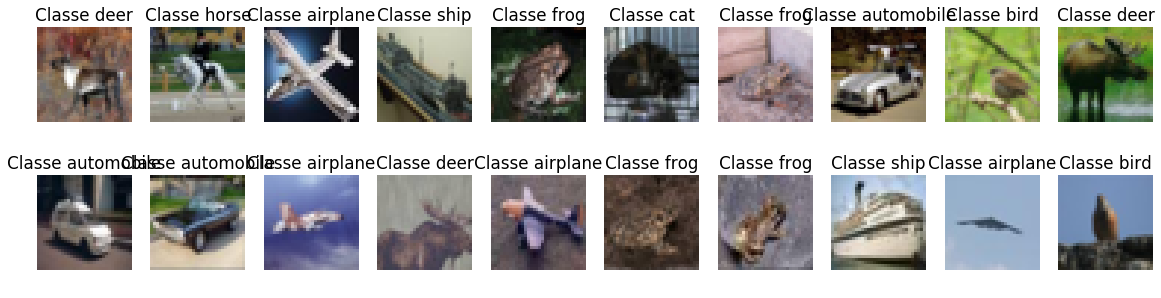

In [0]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Classe {}".format( labels[int(y_train[img_i])] ))
        axes[i][j].axis("off")
plt.show()

In [0]:
'''
Constroi a base de dados contendo apenas as classes
pertencentes ao vetor 'classes'
A parâmetro 'dici' representa o dicionário que mapeia
o identificador da classe original para o novo identificador
que varia de 0 à n, sendo n o tamanho do vetor 'classes'.
'''
def separaBase(classes, x_train, y_train, dici):
    x = []
    y = []
    for count in range(len(x_train)):
        if y_train[count] in classes:
            x.append(x_train[count])
            y.append(dici[int(y_train[count])])
    
    x = np.array(x)
    y = np.array(y)
    return x, y

a_x_train, a_y_train = separaBase(np.array([0,1,3,5,6,7,8,9]), x_train, y_train,{0:0,1:1,3:2,5:3,6:4,7:5,8:6, 9:7})
b_x_train,b_y_train = separaBase(np.array([2,4]), x_train, y_train,{2:0,4:1})

a_x_test, a_y_test = separaBase(np.array([0,1,3,5,6,7,8,9]), x_test, y_test,{0:0,1:1,3:2,5:3,6:4,7:5,8:6,9:7})
b_x_test,b_y_test = separaBase(np.array([2,4]), x_test, y_test,{2:0,4:1})

### Base A

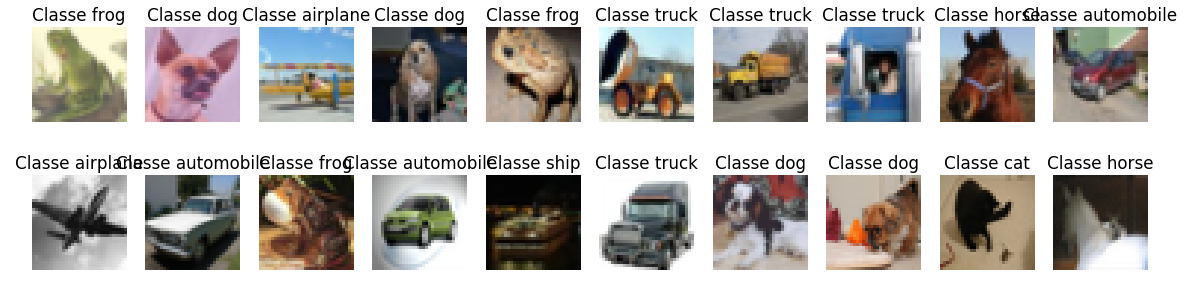

In [0]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, a_x_train.shape[0])
        axes[i][j].imshow(a_x_train[img_i], cmap="gray")
        axes[i][j].set_title("Classe {}".format(a_labels[int(a_y_train[img_i])] ))
        axes[i][j].axis("off")
plt.show()

### Base B

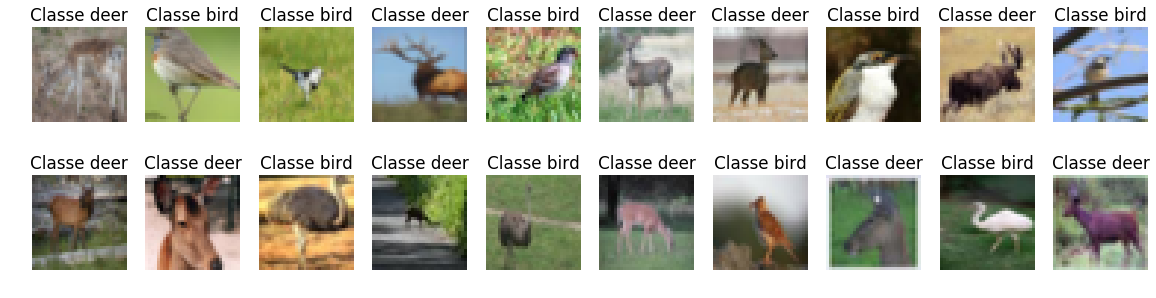

In [0]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, b_x_train.shape[0])
        axes[i][j].imshow(b_x_train[img_i], cmap="gray")
        axes[i][j].set_title("Classe {}".format(b_labels[int(b_y_train[img_i])] ))
        axes[i][j].axis("off")
plt.show()

## Pré-processamento

In [0]:
# Normaliza a intensidade dos pixels para o intervalo [0, 1]
x_train = x_train/255
a_x_train = a_x_train/255
b_x_train = b_x_train/255
x_test = x_test/255
a_x_test = a_x_test/255
b_x_test = b_x_test/255

# Alterando a representação de classes
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
a_y_train = np_utils.to_categorical(a_y_train,8)
a_y_test = np_utils.to_categorical(a_y_test,8)
b_y_train = np_utils.to_categorical(b_y_train,2)
b_y_test = np_utils.to_categorical(b_y_test,2)

# Pega o número de classes
n_classes = a_y_train.shape[1]
print('numero de classes {}'.format(n_classes))

numero de classes 8


## Funções auxiliares

In [0]:
'''
Classe criada para armazenar resultados
'''
class Resultados:   
    def __init__(self):
        self.treino = None
        self.history = None
        self.y_proba = None
        self.y_pred = None
        self.y_true = None
        self.x_test = x_test

#gera os gráficos dos resultados do treinamento do modelo
def gerar_graficos_treino(history):
    mpl.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))

    # Loss
    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
            label="Train Loss", color="royalblue", lw=3)
    axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
            label="Val Loss", color="forestgreen", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1))
    axes[0].legend()

    # Accuracy
    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
            label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
            label="Val ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1))
    axes[1].legend()
    return plt

#gera uma matriz de confusão
def gerar_matriz_confusao(y_pred, y_true):
    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = list(range(1, 11))
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Matriz de Confusão",
           ylabel="Real",
           xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    return plt

'''
gera um gráfico que mostra alguns exemplos de imagens
que foram classificadas de forma errada pelo modelo
'''
def gerar_grafico_imgs_erradas(x_test, y_pred,y_true, labels):
    missed = y_pred != y_true

    x_missed = x_test[missed]
    y_missed = y_pred[missed]
    y_true_missed = y_true[missed]

    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

    for i in range(n_rows):
        for j in range(n_cols):
            img_i = np.random.randint(0, x_missed.shape[0])
            axes[i][j].imshow(x_missed[img_i, :, :, :], cmap="gray")
            axes[i][j].set_title("{} (o certo era {})".format(labels[int(y_missed[img_i])], labels[int(y_true_missed[img_i])] ))
            axes[i][j].axis("off")
    return plt

#gera uma representação dos kerneis aprendidos pelo modelo
def gerar_grafico_kernels(model):
    # Pega na camada Conv1 os pesos dos filtros (no indice 0, o indice 1 são os bias)
    kernels = model.get_layer("Conv1").get_weights()[0]

    n_rows = 4
    n_cols = 8
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))

    for k in range(kernels.shape[3]):
        i = k//n_cols
        j = k%n_cols
        axes[i][j].imshow(kernels[:, :, 0, k], cmap="gray")
        axes[i][j].axis("off")
    return plt

#gera uma representação t-sne
def gerar_representacao(x_test, y_true, model, model_input, n_classes, labels):
    # Pega a camada Flatten
    flatten = model.get_layer("Flatten")

    # Cria um modelo intermediario cuja saida é a representação do dado na Flatten
    int_model = models.Model(model_input, flatten.output)

    # Gera a representação nos dados de teste
    flatten_out = int_model.predict(x_test)

    # Roda o PCA seguido do t-SNE
    pca_out = PCA(50).fit_transform(flatten_out)
    tsne_out = TSNE().fit_transform(pca_out)

    colors = ["red", "royalblue", "forestgreen", "darkorchid", "chocolate", "maroon", "indigo", "slategray", "mediumblue", "y"]

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(tsne_out[:, 0], tsne_out[:, 1], color=[colors[i] for i in y_true])
    ax.legend(handles=[mpl.patches.Patch(color=colors[i], label=labels[i]) for i in range(n_classes)])
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + x_range*0.2)
    plt.title("Visualização t-SNE")
    plt.ylabel("Dimensão 2")
    plt.xlabel("Dimensão 1")
    return plt


## Modelo

In [0]:
#cria e compila o modelo de rede
def rede(img_shape, n_classes):
    model_input = layers.Input(shape=img_shape, name="Input")

    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1")(model_input)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool1")(x)
    x = layers.Dropout(0.25, name="Dropout1")(x)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3")(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool2")(x)
    x = layers.Dropout(0.25, name="Dropout2")(x)

    x = layers.Flatten(name="Flatten")(x)

    x = layers.Dense(128, activation="relu", name="Dense1")(x)
    x = layers.Dense(64, activation="relu", name="Dense2")(x)

    model_output = layers.Dense(n_classes, activation="softmax", name="Output")(x)

    model = models.Model(model_input, model_output)
    model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model, model_input

'''
cria um novo modelo e realiza o transfer learning do modelo_treinado 
para acordo o novo modelo de acordo com o parâmetro 'tipo'
'''
def transferencia(modelo_treinado, img_shape, tipo, n_classes):
    qnt = 11 if tipo == 1 else 10
    
    layers = [modelo_treinado.get_layer(index = x) for x in range(qnt)]
    model, model_input = rede(img_shape,n_classes)
    
    for x in range(len(layers)):
        model.get_layer(index = x).trainable = False
        model.get_layer(index = x).set_weights(layers[x].get_weights())
        print("Camada {0} transferida".format(layers[x].get_config()['name'] ))
    
    model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model, model_input

## Resultados

### Modelo A

In [0]:
modelA, model_inputA = rede(img_shape, a_y_train.shape[1])
modelA.summary()

# Treina por 20 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
graficosA =  Resultados()
graficosA.history = modelA.fit(a_x_train, a_y_train, batch_size=32, epochs=20,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

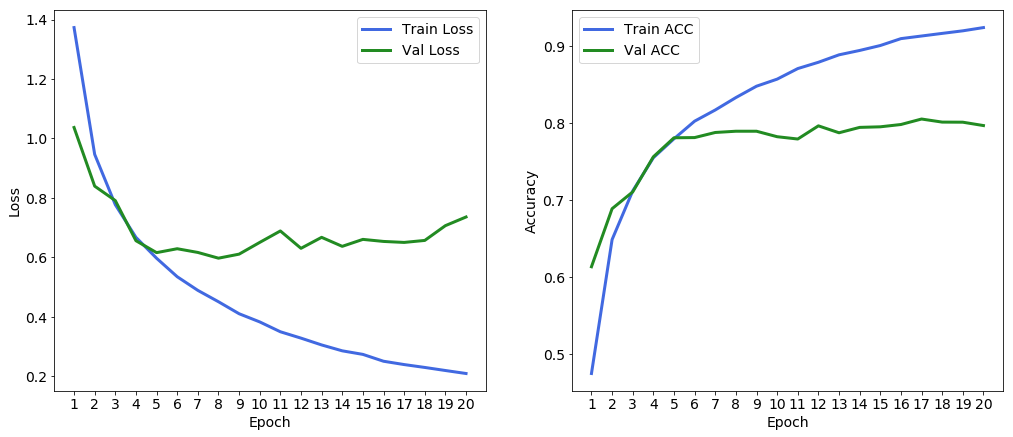

In [0]:
graficosA.y_proba = modelA.predict(a_x_test)
graficosA.y_pred =  np.argmax(graficosA.y_proba, axis=1)
graficosA.y_true = np.argmax(a_y_test, axis=1)
gerar_graficos_treino(graficosA.history).show()

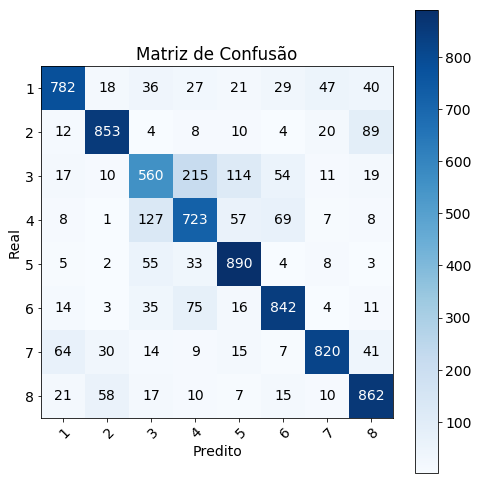

In [0]:
gerar_matriz_confusao(graficosA.y_pred, graficosA.y_true).show()

#### Exemplos Errados

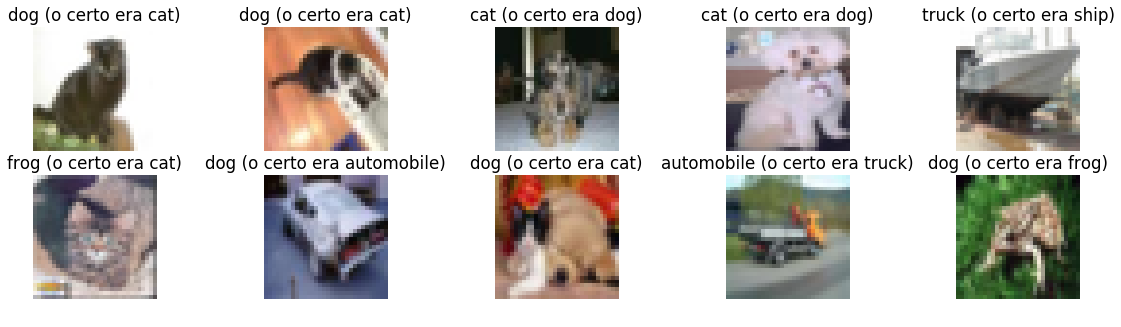

In [0]:
gerar_grafico_imgs_erradas(a_x_test, graficosA.y_pred, graficosA.y_true, a_labels).show()

#### Visualização do Modelo

##### Filtros na Primeira Camada

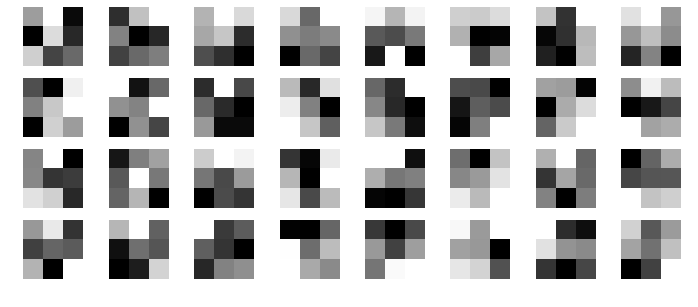

In [0]:
# Pega na camada Conv1 os pesos dos filtros (no indice 0, o indice 1 são os bias)
gerar_grafico_kernels(modelA).show()

##### Representação

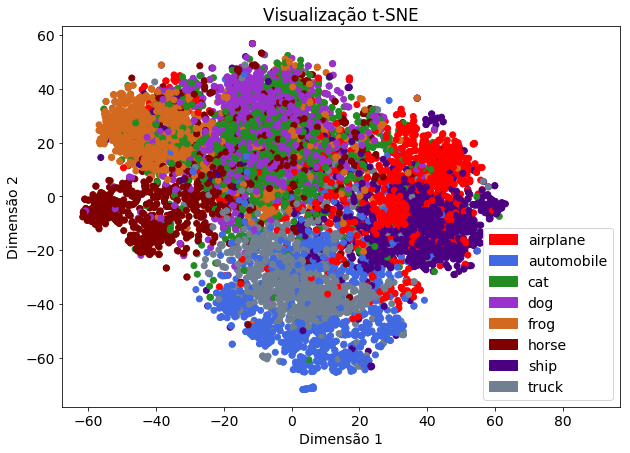

In [0]:
gerar_representacao(a_x_test, graficosA.y_true, modelA, model_inputA, a_y_train.shape[1], a_labels).show()

### Modelo B

In [0]:
n_classes = b_y_train.shape[1]
modelB, model_inputB = rede(img_shape, b_y_train.shape[1])
modelB.summary()

# Treina por 20 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
graficosB =  Resultados()
graficosB.history = modelB.fit(b_x_train, b_y_train, batch_size=32, epochs=20,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

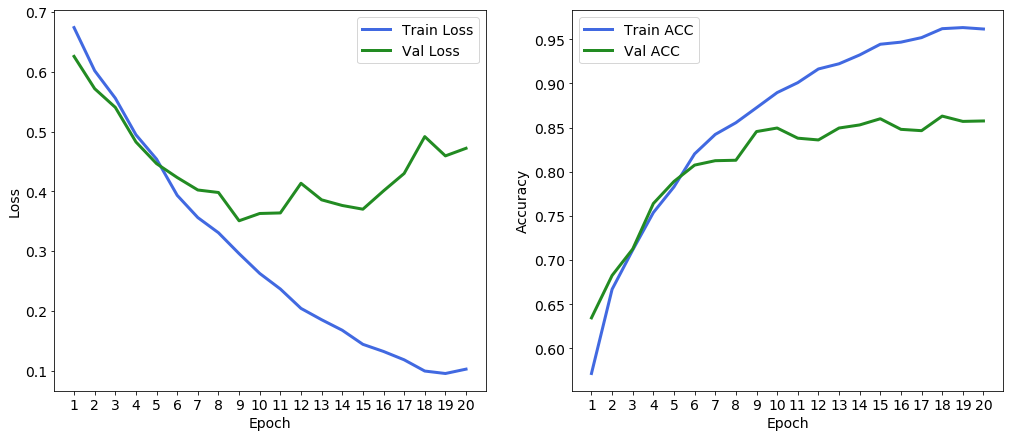

In [0]:
graficosB.y_proba = modelB.predict(b_x_test)
graficosB.y_pred =  np.argmax(graficosB.y_proba, axis=1)
graficosB.y_true = np.argmax(b_y_test, axis=1)
gerar_graficos_treino(graficosB.history).show()

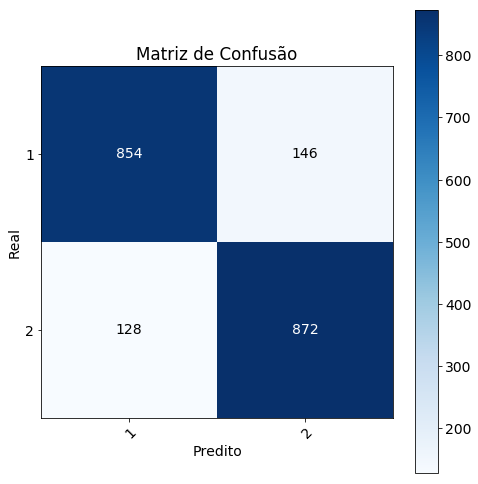

In [0]:
gerar_matriz_confusao(graficosB.y_pred, graficosB.y_true).show()

#### Exemplos Errados

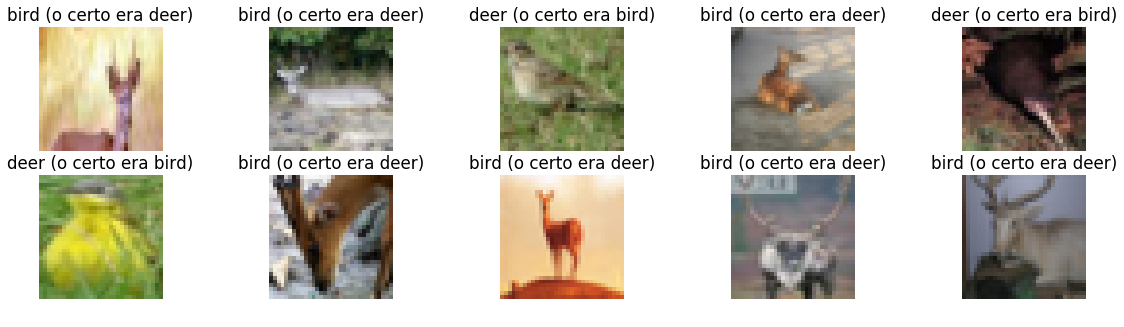

In [0]:
gerar_grafico_imgs_erradas(b_x_test, graficosB.y_pred, graficosB.y_true, b_labels).show()

#### Visualização do Modelo

##### Filtros na Primeira Camada

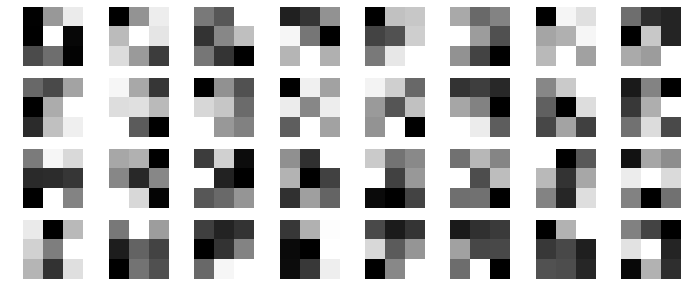

In [0]:
# Pega na camada Conv1 os pesos dos filtros (no indice 0, o indice 1 são os bias)
gerar_grafico_kernels(modelB).show()

##### Representação

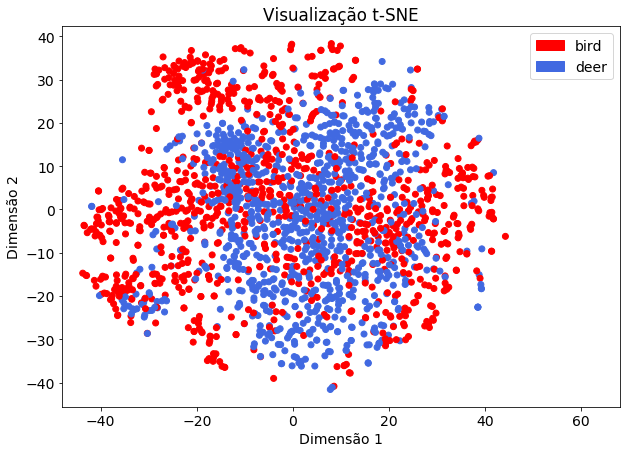

In [0]:
gerar_representacao(b_x_test, graficosB.y_true, modelB, model_inputB, b_y_train.shape[1], b_labels).show()

### Modelo B Fine tuning 1

In [0]:
modelB_fine1, model_inputB_fine1 = transferencia(modelA, img_shape, 1, b_y_train.shape[1])
modelB_fine1.summary()

# Treina por 20 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
graficosB_fine1 =  Resultados()
graficosB_fine1.history = modelB_fine1.fit(b_x_train, b_y_train, batch_size=32, epochs=20,validation_split=0.2)

Camada Input transferida
Camada Conv1 transferida
Camada Conv2 transferida
Camada Pool1 transferida
Camada Dropout1 transferida
Camada Conv3 transferida
Camada Conv4 transferida
Camada Pool2 transferida
Camada Dropout2 transferida
Camada Flatten transferida
Camada Dense1 transferida
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0

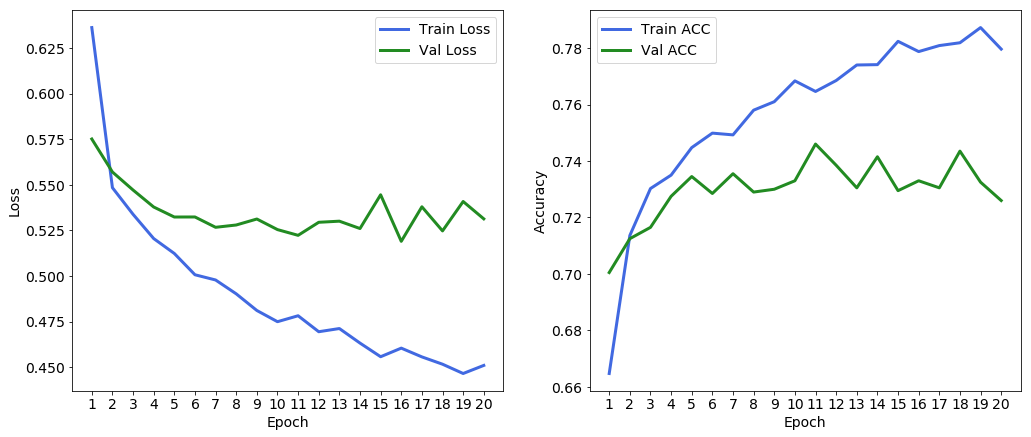

In [0]:
graficosB_fine1.y_proba = modelB_fine1.predict(b_x_test)
graficosB_fine1.y_pred =  np.argmax(graficosB_fine1.y_proba, axis=1)
graficosB_fine1.y_true = np.argmax(b_y_test, axis=1)
gerar_graficos_treino(graficosB_fine1.history).show()

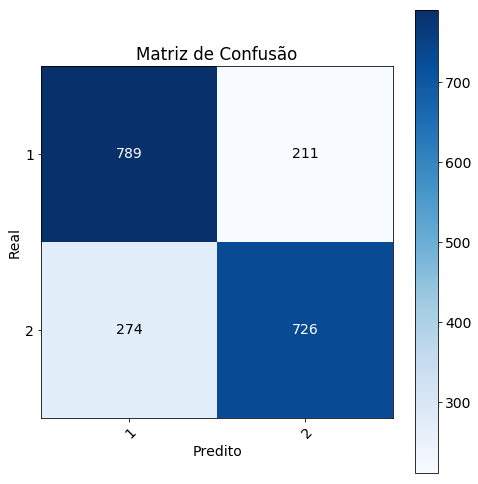

In [0]:
gerar_matriz_confusao(graficosB_fine1.y_pred, graficosB_fine1.y_true).show()

#### Exemplos Errados

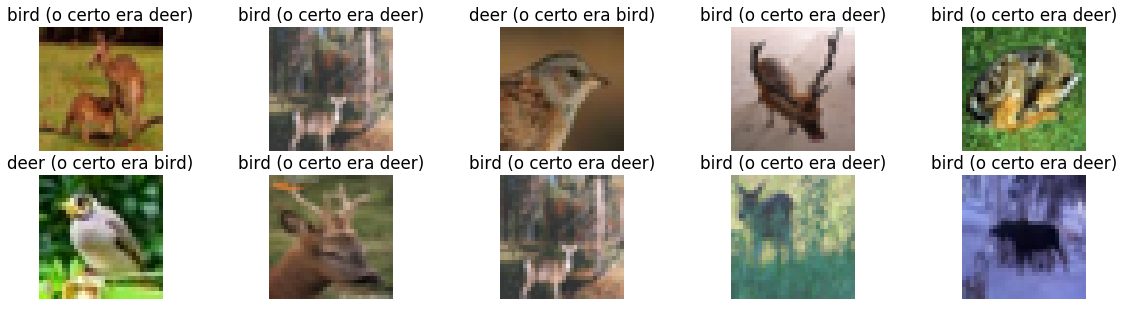

In [0]:
gerar_grafico_imgs_erradas(b_x_test, graficosB_fine1.y_pred, graficosB_fine1.y_true, b_labels).show()

#### Visualização do Modelo

##### Filtros na Primeira Camada

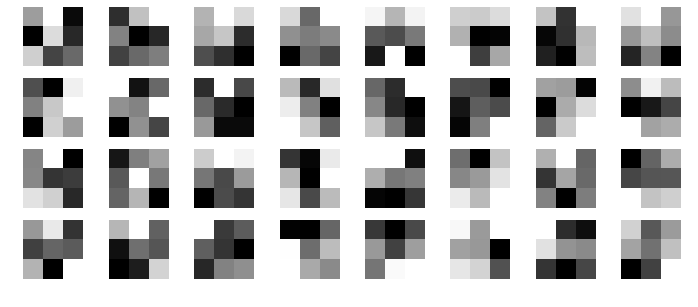

In [0]:
# Pega na camada Conv1 os pesos dos filtros (no indice 0, o indice 1 são os bias)
gerar_grafico_kernels(modelB_fine1).show()

##### Representação

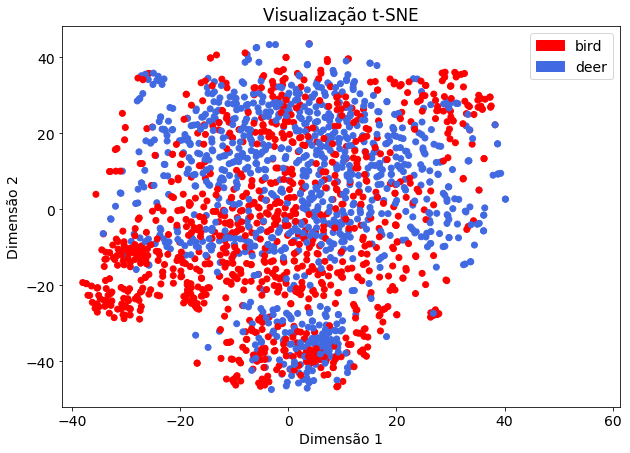

In [0]:
gerar_representacao(b_x_test, graficosB_fine1.y_true, modelB_fine1, model_inputB_fine1, b_y_train.shape[1], b_labels).show()

### Modelo B Fine tuning 2


In [0]:
modelB_fine2, model_inputB_fine2 = transferencia(modelA, img_shape, 2, b_y_train.shape[1])
modelB_fine2.summary()

# Treina por 20 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
graficosB_fine2 =  Resultados()
graficosB_fine2.history = modelB_fine2.fit(b_x_train, b_y_train, batch_size=32, epochs=20,validation_split=0.2)

Camada Input transferida
Camada Conv1 transferida
Camada Conv2 transferida
Camada Pool1 transferida
Camada Dropout1 transferida
Camada Conv3 transferida
Camada Conv4 transferida
Camada Pool2 transferida
Camada Dropout2 transferida
Camada Flatten transferida
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
________________

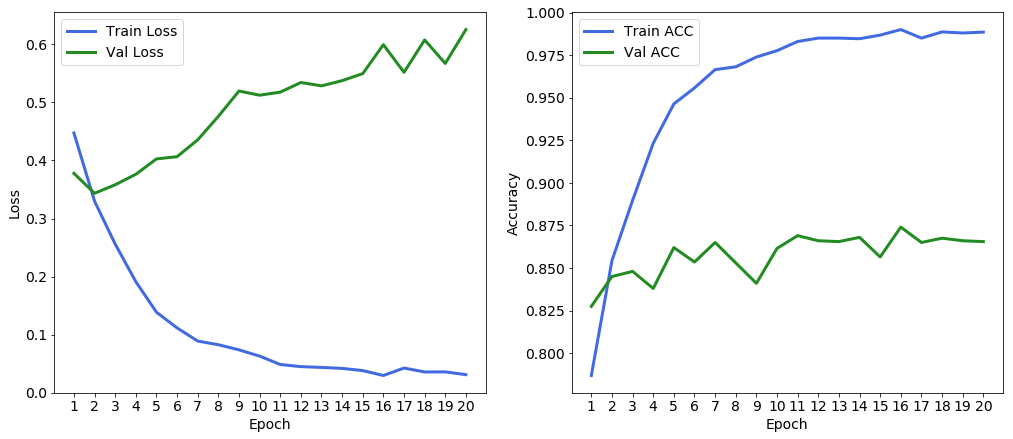

In [0]:
graficosB_fine2.y_proba = modelB_fine2.predict(b_x_test)
graficosB_fine2.y_pred =  np.argmax(graficosB_fine2.y_proba, axis=1)
graficosB_fine2.y_true = np.argmax(b_y_test, axis=1)

gerar_graficos_treino(graficosB_fine2.history).show()

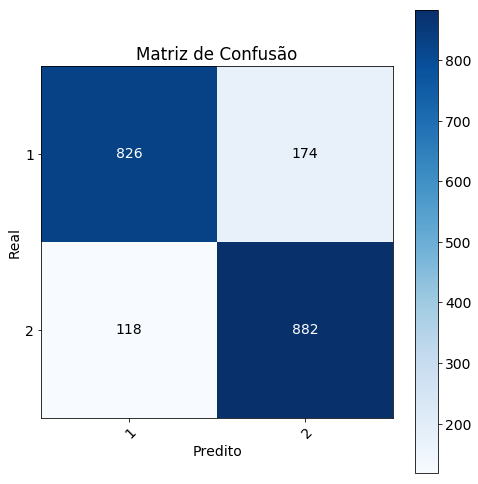

In [0]:
gerar_matriz_confusao(graficosB_fine2.y_pred, graficosB_fine2.y_true).show()

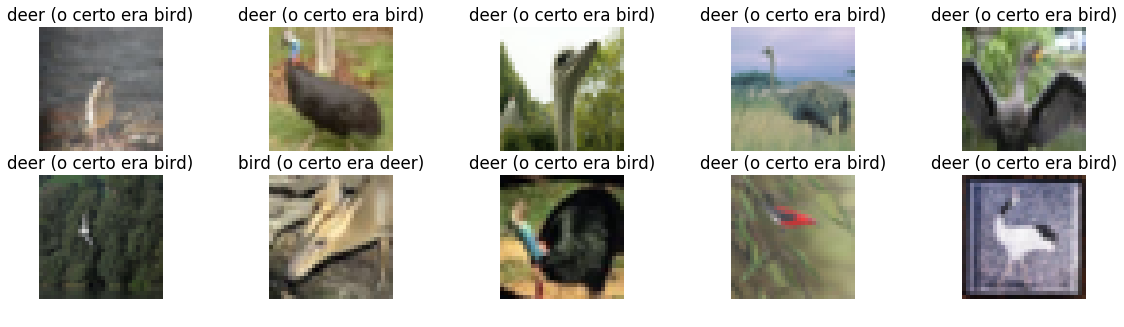

In [0]:
gerar_grafico_imgs_erradas(b_x_test, graficosB_fine2.y_pred, graficosB_fine2.y_true, b_labels).show()

#### Visualização do Modelo

##### Filtros na Primeira Camada

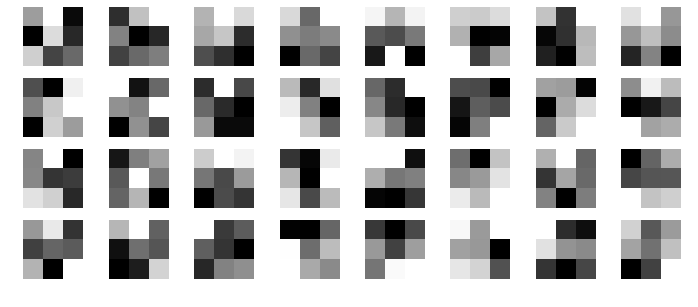

In [0]:
# Pega na camada Conv1 os pesos dos filtros (no indice 0, o indice 1 são os bias)
gerar_grafico_kernels(modelB_fine2).show()

##### Representação

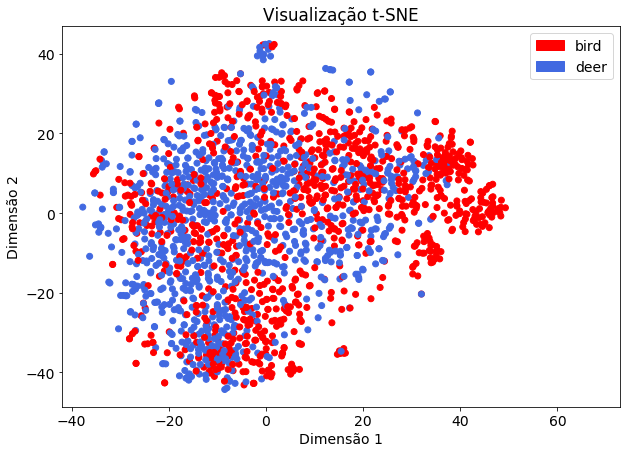

In [0]:
gerar_representacao(b_x_test, graficosB_fine2.y_true, modelB_fine2, model_inputB_fine2, b_y_train.shape[1], b_labels).show()

##Resultados

### Graficos de treinamento

#### Modelo A

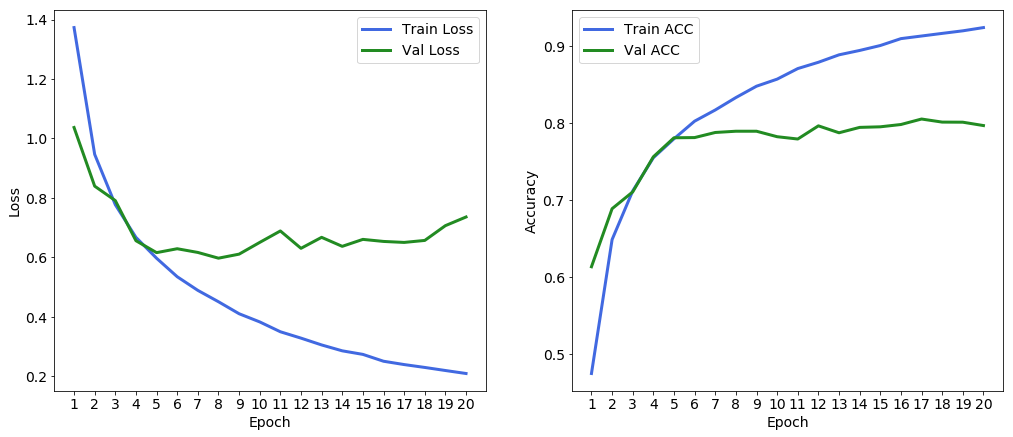

In [0]:
gerar_graficos_treino(modelA.history).show()

#### Modelo B

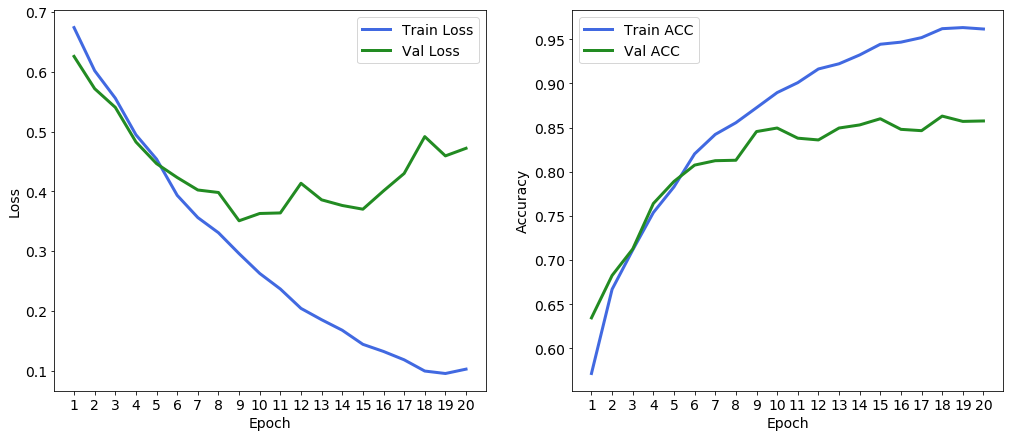

In [0]:
gerar_graficos_treino(modelB.history).show()

#### Modelo B fine tuning 1

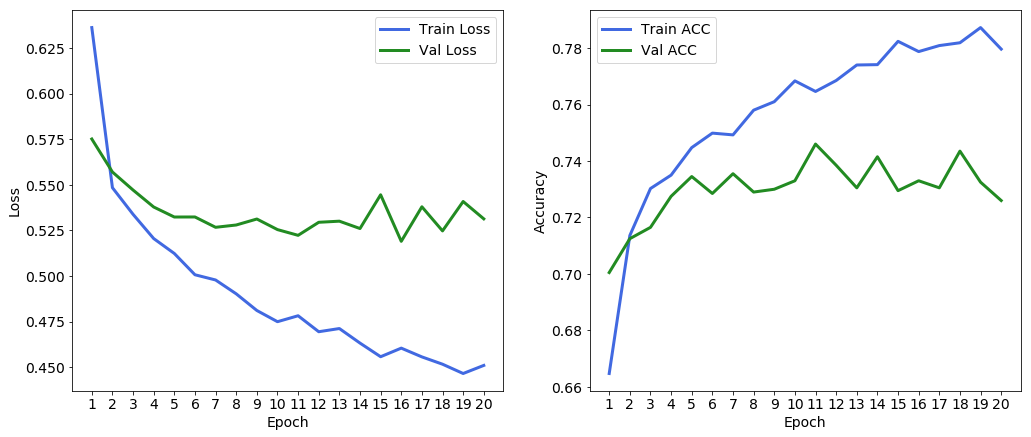

In [0]:
gerar_graficos_treino(modelB_fine1.history).show()

#### Modelo B fine tuning 2

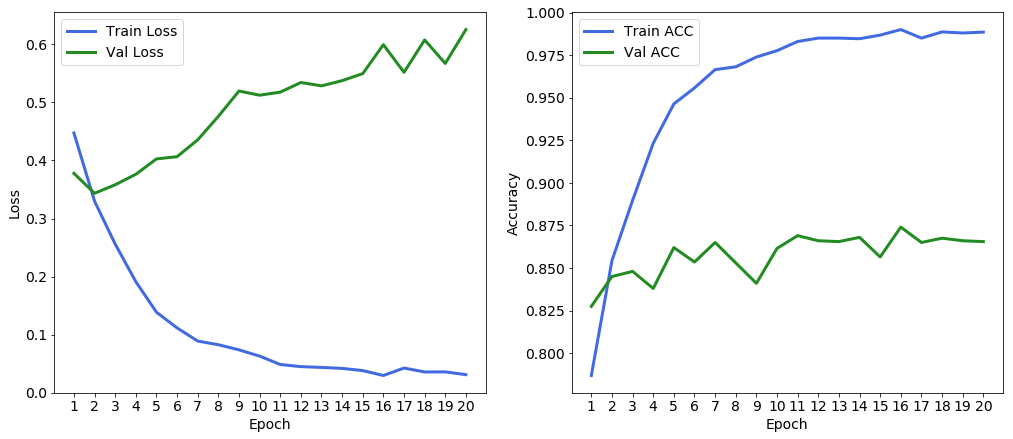

In [0]:
gerar_graficos_treino(modelB_fine2.history).show()

É possível notar que o método de transferência de conhecimento melhora o estado inicial do treinamento do modelo. Todos os modelos B que passaram por esse método começaram o treino com um desempenho superior ao do inicio do modelo B.

---

Com relação ao fine tuning,  o  segundo modelo obteve um desempenho  superior ao primeiro. Isso pode ser devido ao fato de que o segundo modelo treinou as duas camadas densas enquanto o primeiro treinou apenas a primeira camada. Apesar da transferência de conhecimento a respeito da representação, o primeiro modelo não conseguiu ajustar a rede treinando apenas uma camada densa e obteve um desempenho inferior ao do modelo B sem transferência de conhecimento

### Matrizes de confusão

#### Modelo B 

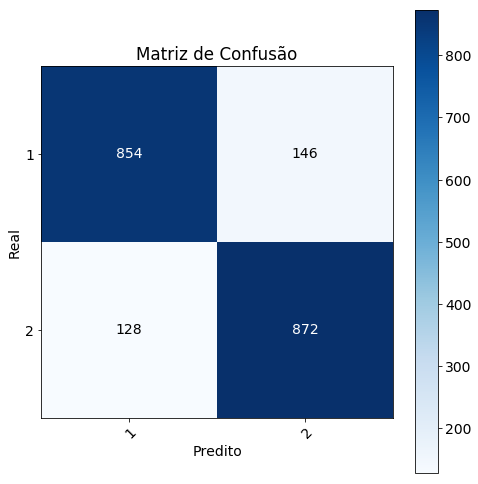

In [0]:
gerar_matriz_confusao(graficosB.y_pred, graficosB.y_true).show()

#### Modelo B fine tuning 1

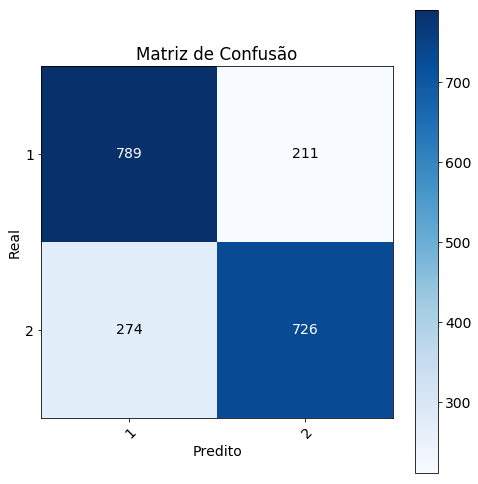

In [0]:
gerar_matriz_confusao(graficosB_fine1.y_pred, graficosB_fine1.y_true).show()

#### Modelo B fine tuning 2

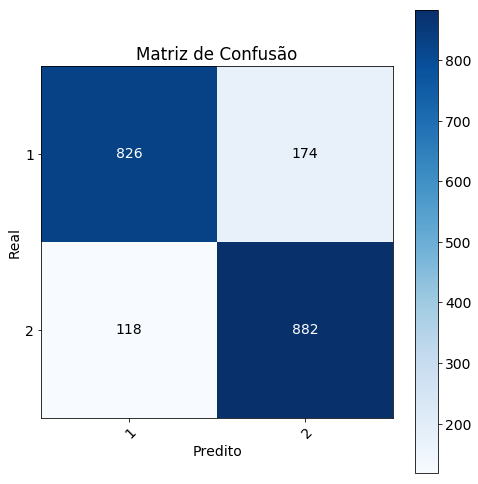

In [0]:
gerar_matriz_confusao(graficosB_fine2.y_pred, graficosB_fine2.y_true).show()

Apesar da função de perda com relação a partição de validação piorar no fine tune de duas camadas, a matriz de confusão demonstra que este modelo obteve uma performance melhor do que o modelo onde o treinamento ocorreu apenas na última camada densa.

---

Além disso, é possível notar também que o modelo fine tuning 1 obteve um desempenho pior do que o modelo B que não passou pelo fine tuning. Aparentemente, o fato da rede poder treinar apenas uma camada limitou severamente a capacidade de aprendizagem do modelo.

### Representação dos modelos

#### Modelo B

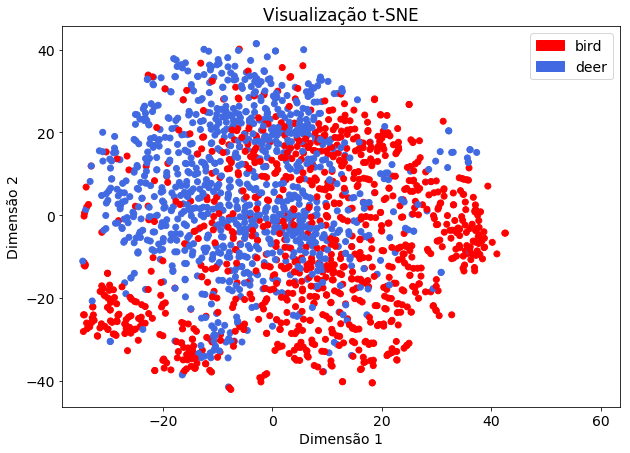

In [0]:
gerar_representacao(b_x_test, graficosB.y_true, modelB, model_inputB, b_y_train.shape[1], b_labels).show()


#### Modelo B fine tuning 1

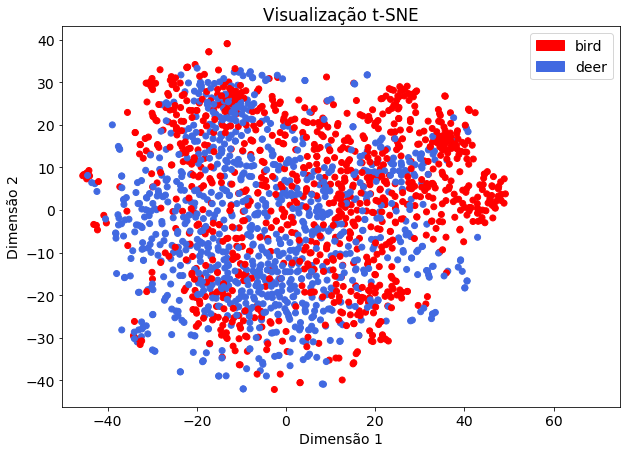

In [0]:
gerar_representacao(b_x_test, graficosB_fine1.y_true, modelB_fine1, model_inputB_fine1, b_y_train.shape[1], b_labels).show()


#### Modelo B fine tuning 2

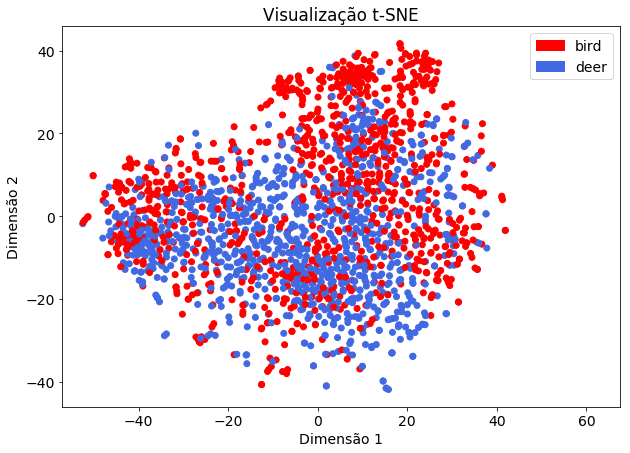

In [0]:
gerar_representacao(b_x_test, graficosB_fine2.y_true, modelB_fine2, model_inputB_fine2, b_y_train.shape[1], b_labels).show()


### Métricas

In [0]:
print('\n\t\tClassification Report Modelo A\n',
      metrics.classification_report(graficosA.y_true, graficosA.y_pred))
print('\n\t\tClassification Report Modelo B\n',
      metrics.classification_report(graficosB.y_true, graficosB.y_pred))
print('\n\tClassification Report Modelo B fine tuning 1\n',
      metrics.classification_report(graficosB_fine1.y_true, graficosB_fine1.y_pred))
print('\n\tClassification Report Modelo B fine tuning 2\n',
      metrics.classification_report(graficosB_fine2.y_true, graficosB_fine2.y_pred))


		Classification Report Modelo A
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1000
           1       0.87      0.85      0.86      1000
           2       0.66      0.56      0.61      1000
           3       0.66      0.72      0.69      1000
           4       0.79      0.89      0.84      1000
           5       0.82      0.84      0.83      1000
           6       0.88      0.82      0.85      1000
           7       0.80      0.86      0.83      1000

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000


		Classification Report Modelo B
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.86      0.87      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighte

As métricas mostrada acima confirmam os graficos gerados durante o treinamento já que a base de teste não foi vista pelo modelo durante o processo de treinamento. O modelo B fine tuning 2 obteve resultados semelhantes aos do modelo B entretanto ele precisaria de menos épocas de treinamento para alcançar este resultado. 

Por outro lado, o modelo B fine tuning 1 teve um desempenho limidado devido ao número de camadas que puderam ser treinadas. Apesar do modelo fine tuning 1 ter uma avaliação melhor no inicio do treinamento, o resultado final é inferior ao do modelo B que não passou pela transferência de conhecimento.